In [1]:
import Tiled_Classification_RF as TCRF
import os, tempfile
from osgeo import gdal, ogr, gdal_array # I/O image data
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
from sklearn.ensemble import RandomForestClassifier # classifier
import pandas as pd # handling large data as table sheets
import geopandas as gpd # handling large data as shapefiles
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix  # calculating measures for accuracy assessment
import datetime
from xgboost import XGBClassifier
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()
from GIStools.GIStools import preprocess_SfM_inputs
from GIStools.Stitch_Rasters import stitch_rasters
from GIStools.Grid_Creation import create_grid
from GIStools.Raster_Matching import pad_rasters_to_largest
from RF_input_parameters import TrainerParameters


In [2]:
#-------------------Required User Defined Inputs-------------------#
params = TrainerParameters()

DEM_path = params.DEM_path
ortho_path = params.ortho_path
output_folder = params.output_folder
training_path = params.training_path
validation_path = params.validation_path
attribute = params.attribute
grid_path = params.grid_path
est = params.est
n_cores = params.n_cores
gradient_boosting = params.gradient_boosting
verbose = params.verbose
stitch = params.stitch

#--------------------Input Preparation-----------------------------#
#Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder) 

#List of grid-clipped images to classify and associated id values
in_dir = os.path.join(output_folder, 'RF_Tiled_Inputs')
#output folder for list of img_path_list grid-clipped classified images

# directory, where the classification image should be saved:
results_folder = os.path.join(output_folder, 'RF_Results')
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
classification_image = os.path.join(results_folder, 'Classified_Training_Image.tif')


In [3]:
#==================== Preprocessing ====================#
    #Create grid cells to process large rasters in chunks. 
#Each grid cell is the size of the extent training and validation shapefiles
if grid_path is None:
    train_tile_id, grid_path, _ = create_grid([training_path,validation_path], DEM_path, in_dir)
    print('Training Grid ID: {}'.format(train_tile_id)) 
else:
    grid = gpd.read_file(grid_path)
    train_tile_id = params.train_tile_id
if params.tile_dir is not None:
    in_dir = params.tile_dir
train_tile_path = os.path.join(in_dir, f'stacked_bands_tile_input_{train_tile_id}.tif') # grid-clipped-image containing the training data
results_txt = os.path.join(output_folder, 'Results_Summary.txt') # directory, where the all meta results will be saved
TCRF.print_header(results_txt, DEM_path, ortho_path, train_tile_path, training_path, validation_path, train_tile_path, attribute) # print the header for the results text file

Training Grid ID: 29


Extracting image data from: Y:\ATD\GIS\East_Troublesome\RF Vegetation Filtering\LM2\LM2_2023___070923 - XGB Saved Model\RF_Tiled_Inputs\stacked_bands_tile_input_29.tif
Image extent: 5623 x 10102 (row x col)
Number of Bands: 6
Unique labels values: [1 2 3 4 5 6]
Unique y values: [1 2 3 4 5 6]
Training Random Forest Classifier
OOB prediction of accuracy is: 91.86488736101994%
Model saved to Y:\ATD\GIS\East_Troublesome\RF Vegetation Filtering\LM2 - 070923 - Water added expanded v2\RF_Model.joblib
Band 1 importance: 0.17194192965267777
Band 2 importance: 0.18416139750899288
Band 3 importance: 0.08971374731710081
Band 4 importance: 0.2732336528220585
Band 5 importance: 0.1890817345611773
Band 6 importance: 0.09186753813799277
predict      1      2      3       4      5      6     All
truth                                                     
1        89177      0      0       0      0      0   89177
2            0  55660      0       0      0      0   55660
3            0      0  12018     

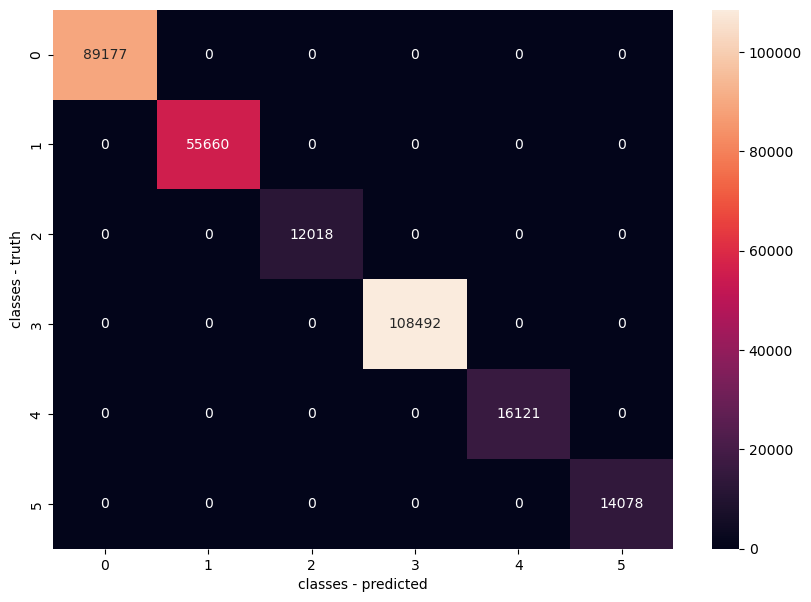

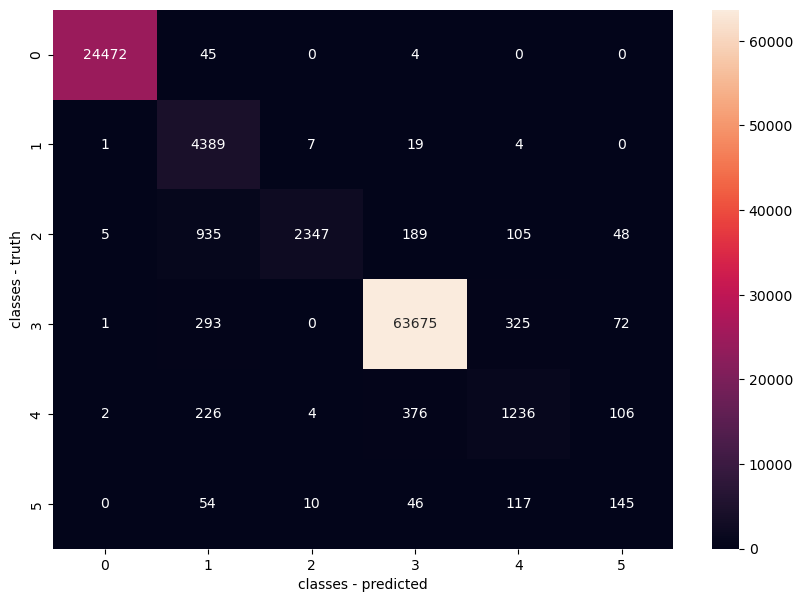

In [4]:

#===========================Main Classification Loop===========================#

train_tile, train_tile_3Darray = TCRF.extract_image_data(train_tile_path, results_txt, est, log=True) # extract the training tile image data
# Extract training data from shapefile
X_train, y_train, labels, roi = TCRF.extract_shapefile_data(training_path, train_tile, train_tile_3Darray, results_txt, attribute, "TRAINING")
#add 0 onto front of y-train and labels to account for 0 values in the classification
rf, rf2 = TCRF.train_RF(X_train, y_train, train_tile, results_txt, output_folder, est, n_cores, 
                            gradient_boosting = gradient_boosting, verbose = verbose) # train the random forest classifier


train_tile_2Darray = TCRF.flatten_raster_bands(train_tile_3Darray) # Convert NaNs to 0.0
class_prediction = TCRF.predict_classification(rf, train_tile_2Darray, train_tile_3Darray) # predict the classification for each pixel using the trained model
masked_prediction = TCRF.reshape_and_mask_prediction(class_prediction, train_tile_3Darray) # mask the prediction to only include bare earth and vegetation
TCRF.save_classification_image(classification_image, train_tile, train_tile_3Darray, masked_prediction) # save the masked classification image
# Extract validation data from shapefile
X_v, y_v, labels_v, roi_v = TCRF.extract_shapefile_data(validation_path, train_tile, class_prediction, results_txt, attribute, "VALIDATION") 
TCRF.model_evaluation(X_v, y_v, labels_v, roi_v, class_prediction, 
                      results_txt, gradient_boosting=gradient_boosting) # evaluate the model using the validation data

del train_tile # close the image dataset